In [168]:
import requests
import pandas as pd
import polars as pl
import numpy as np
import nltk
import matplotlib.pyplot as plt
import textstat

nltk.download('vader_lexicon')
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

pres_debates = pl.read_csv("pres_debates.csv", columns = ["speaker", "type", 'date', 'text', 'candidate', 'year'])

# filter for presidential in the type column
pres_debates = pres_debates.filter(
    pl.col("type") == 'Presidential',
    pl.col('candidate') == 1, 
    pl.col('year') != 2004, 
    pl.col('year') != 1992, 
    pl.col('year') != 1996, 
    pl.col('year') != 1980,
)

display(pres_debates)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\docto\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\docto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


speaker,text,date,candidate,year,type
str,str,str,i64,i64,str
"""TRUMP""","""so, as you know, more 2.2 mill…","""10/22/2020""",1,2020,"""Presidential"""
"""BIDEN""","""220,000 americans dead. if you…","""10/22/2020""",1,2020,"""Presidential"""
"""TRUMP""","""it is not a guarantee but it w…","""10/22/2020""",1,2020,"""Presidential"""
"""TRUMP""","""johnson and johnson is doing v…","""10/22/2020""",1,2020,"""Presidential"""
"""TRUMP""","""no, i think my timeline is goi…","""10/22/2020""",1,2020,"""Presidential"""
…,…,…,…,…,…
"""NIXON""","""i agree with senator kennedy's…","""9/26/1960""",1,1960,"""Presidential"""
"""NIXON""","""not at all. as a matter of fac…","""9/26/1960""",1,1960,"""Presidential"""
"""KENNEDY""","""well, i must say that the reas…","""9/26/1960""",1,1960,"""Presidential"""


In [123]:
date_dict = {group: data for group, data in pres_debates.group_by('date')}
date_dict = {key[0]: value for key, value in date_dict.items()}
print(date_dict.keys())
display(date_dict['10/22/2020'])

dict_keys(['10/15/2008', '9/26/1960', '10/22/2020', '10/21/1984', '10/22/2012', '10/7/1960', '10/3/2012', '10/11/2000', '9/23/1976', '9/25/1988', '10/19/2016', '10/13/1988', '10/3/2000', '10/9/2016', '10/21/1960', '10/17/2000', '10/7/1984', '9/29/2020', '10/22/1976', '10/13/1960', '10/6/1976', '10/16/2012', '10/7/2008', '9/26/2008', '9/26/2016'])


speaker,text,date,candidate,year,type
str,str,str,i64,i64,str
"""TRUMP""","""so, as you know, more 2.2 mill…","""10/22/2020""",1,2020,"""Presidential"""
"""BIDEN""","""220,000 americans dead. if you…","""10/22/2020""",1,2020,"""Presidential"""
"""TRUMP""","""it is not a guarantee but it w…","""10/22/2020""",1,2020,"""Presidential"""
"""TRUMP""","""johnson and johnson is doing v…","""10/22/2020""",1,2020,"""Presidential"""
"""TRUMP""","""no, i think my timeline is goi…","""10/22/2020""",1,2020,"""Presidential"""
…,…,…,…,…,…
"""TRUMP""","""is he gonna get china to do it…","""10/22/2020""",1,2020,"""Presidential"""
"""BIDEN""","""no, i'm going to rejoin the pa…","""10/22/2020""",1,2020,"""Presidential"""
"""TRUMP""","""but that'll cost you $1 trilli…","""10/22/2020""",1,2020,"""Presidential"""


In [124]:
pattern = r"[^\w\s]"

words_by_speaker = {}

for i in date_dict.keys():
    unique_speakers = date_dict[i]['speaker'].unique()
    words_by_speaker[i] = {}

    for speaker in unique_speakers:
       words_by_speaker[i][speaker] = (
        date_dict[i].filter(pl.col("speaker") == speaker)
        .select(pl.col("text"))
        .to_series()
        .str.replace_all(pattern, "")  # Remove punctuation
        .str.split(by=" ")  # Split into words
        .explode()  # Flatten the list
        .to_list()
    )
    
    print(i)
    print(words_by_speaker[i].keys())

10/15/2008
dict_keys(['MCCAIN', 'OBAMA'])
9/26/1960
dict_keys(['WARREN', 'KENNEDY', 'NIXON'])
10/22/2020
dict_keys(['TRUMP', 'BIDEN'])
10/21/1984
dict_keys(['MONDALE', 'REAGAN'])
10/22/2012
dict_keys(['ROMNEY', 'OBAMA'])
10/7/1960
dict_keys(['NIXON', 'KENNEDY'])
10/3/2012
dict_keys(['ROMNEY', 'OBAMA'])
10/11/2000
dict_keys(['BUSH', 'GORE'])
9/23/1976
dict_keys(['FORD', 'CARTER'])
9/25/1988
dict_keys(['BUSH', 'DUKAKIS'])
10/19/2016
dict_keys(['CLINTON', 'TRUMP'])
10/13/1988
dict_keys(['DUKAKIS', 'BUSH'])
10/3/2000
dict_keys(['GORE', 'BUSH'])
10/9/2016
dict_keys(['CLINTON', 'TRUMP'])
10/21/1960
dict_keys(['EDWARDS', 'KENNEDY', 'NIXON'])
10/17/2000
dict_keys(['BUSH', 'GORE'])
10/7/1984
dict_keys(['REAGAN', 'MONDALE'])
9/29/2020
dict_keys(['TRUMP', 'BIDEN'])
10/22/1976
dict_keys(['CARTER', 'FORD'])
10/13/1960
dict_keys(['NIXON', 'KENNEDY'])
10/6/1976
dict_keys(['CARTER', 'FORD'])
10/16/2012
dict_keys(['OBAMA', 'ROMNEY'])
10/7/2008
dict_keys(['OBAMA', 'MCCAIN'])
9/26/2008
dict_keys(['MCCAIN

In [134]:
winners = {
    1960: "KENNEDY",
    1964: "JOHNSON",
    1968: "NIXON",
    1972: "NIXON",
    1976: "CARTER",
    1980: "REAGAN",
    1984: "REAGAN",
    1988: "BUSH",
    1992: "CLINTON",
    1996: "CLINTON",
    2000: "BUSH",
    2004: "BUSH",
    2008: "OBAMA",
    2012: "OBAMA",
    2016: "TRUMP",
    2020: "BIDEN"
}

word_count_ratio = [] # winner/loser word count per debate

for i in date_dict.keys():
    year = i.split("/")[-1]
    prez_winner = winners[int(year)]
    
    winner_word_count = len(words_by_speaker[i][prez_winner])
    loser = next((key for key in words_by_speaker[i].keys() if key != prez_winner), None)
    loser_word_count = len(words_by_speaker[i][loser])

    word_count_ratio.append(winner_word_count/loser_word_count)
    print(f"The winner of the {year} debate had {winner_word_count} words, and the loser had {loser_word_count} words. The ratio of the two is {winner_word_count/loser_word_count}.")

The winner of the 2008 debate had 7336 words, and the loser had 6636 words. The ratio of the two is 1.1054852320675106.
The winner of the 1960 debate had 4766 words, and the loser had 271 words. The ratio of the two is 17.58671586715867.
The winner of the 2020 debate had 7014 words, and the loser had 7647 words. The ratio of the two is 0.9172224401726167.
The winner of the 1984 debate had 5073 words, and the loser had 5446 words. The ratio of the two is 0.9315093646713184.
The winner of the 2012 debate had 7174 words, and the loser had 7671 words. The ratio of the two is 0.9352105331769001.
The winner of the 1960 debate had 4486 words, and the loser had 4394 words. The ratio of the two is 1.0209376422394174.
The winner of the 2012 debate had 7283 words, and the loser had 7316 words. The ratio of the two is 0.9954893384363039.
The winner of the 2000 debate had 7674 words, and the loser had 6371 words. The ratio of the two is 1.2045204834405903.
The winner of the 1976 debate had 5807 wor

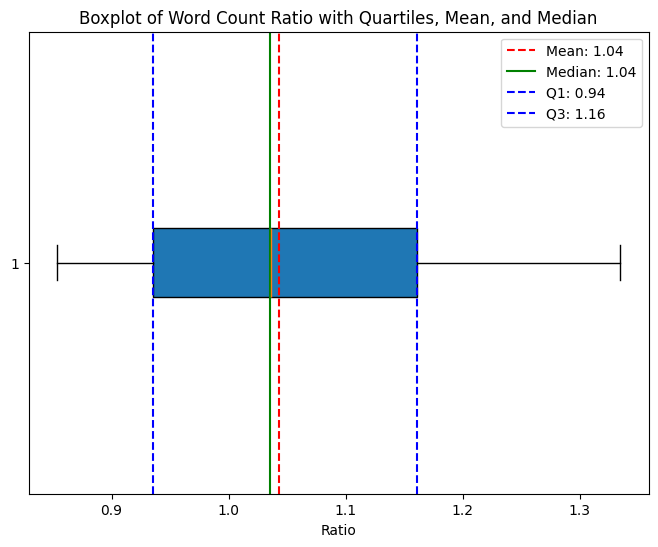

There are outliers from the 1960 debates between John F Kennedy and Nixon, Kennedy spoke significantly more than Nixon in two of the debates, we removed these for the plot.


In [173]:
q1 = np.percentile(word_count_ratio, 25)
q3 = np.percentile(word_count_ratio, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the data to remove outliers
filtered_data = [x for x in word_count_ratio if lower_bound <= x <= upper_bound]
mean_no_outliers = np.mean(filtered_data)
median_no_outliers = np.median(filtered_data)
q1_no_outliers = np.percentile(filtered_data, 25)
q3_no_outliers = np.percentile(filtered_data, 75)

plt.figure(figsize=(8, 6))
plt.boxplot(word_count_ratio, vert=False, patch_artist=True, showfliers=False)
plt.axvline(mean_no_outliers, color='r', linestyle='--', label=f'Mean: {mean_no_outliers:.2f}')
plt.axvline(median_no_outliers, color='g', linestyle='-', label=f'Median: {median_no_outliers:.2f}')
plt.axvline(q1, color='b', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(q3, color='b', linestyle='--', label=f'Q3: {q3:.2f}')
plt.xlabel('Ratio')
plt.title('Boxplot of Word Count Ratio with Quartiles, Mean, and Median')
plt.legend(loc='upper right')
plt.show()

print('There are outliers from the 1960 debates between John F Kennedy and Nixon, Kennedy spoke significantly more than Nixon in two of the debates, we removed these for the plot.')

In [153]:
transcript_by_speaker = {}

for i in date_dict.keys():
    unique_speakers = date_dict[i]['speaker'].unique()
    transcript_by_speaker[i] = {}

    for speaker in unique_speakers:
        # Concatenate the text segments into one string
        transcript_by_speaker[i][speaker] = (
            date_dict[i].filter(pl.col("speaker") == speaker)
            .select(pl.col("text"))
            .to_series()
            .str.concat(delimiter=" ")  # Concatenate all entries into one string
        )[0]

In [160]:
sentiment_diffs = []

for i in date_dict.keys():
    year = i.split("/")[-1]
    prez_winner = winners[int(year)]

    winner_sentiment = 0
    loser_sentiment = 0

    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Tokenize the transcript into sentences
    sentences = sent_tokenize(transcript_by_speaker[i][prez_winner])

    # Initialize sentiment scores
    total_sentiment = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    num_sentences = len(sentences)

    # Analyze sentiment for each sentence
    for sentence in sentences:
        sentiment = sia.polarity_scores(sentence)

        # Sum sentiment scores
        for key in total_sentiment:
            total_sentiment[key] += sentiment[key]

    # Calculate average sentiment
    average_sentiment = {key: value / num_sentences for key, value in total_sentiment.items()}

    print("Winner Final Sentiment Scores:")
    print(average_sentiment)

    winner_sentiment = average_sentiment['compound']

    loser = next((key for key in words_by_speaker[i].keys() if key != prez_winner), None)
    sentences = sent_tokenize(transcript_by_speaker[i][loser])

    # Initialize sentiment scores
    total_sentiment = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    num_sentences = len(sentences)

    # Analyze sentiment for each sentence
    for sentence in sentences:
        sentiment = sia.polarity_scores(sentence)

        # Sum sentiment scores
        for key in total_sentiment:
            total_sentiment[key] += sentiment[key]

    # Calculate average sentiment
    average_sentiment = {key: value / num_sentences for key, value in total_sentiment.items()}

    print("Loser Final Sentiment Scores:")
    print(average_sentiment)

    loser_sentiment = average_sentiment['compound']
    sentiment_diff = winner_sentiment - loser_sentiment
    sentiment_diffs.append(sentiment_diff)

Winner Final Sentiment Scores:
{'neg': 0.05452486187845307, 'neu': 0.8362127071823212, 'pos': 0.1092734806629834, 'compound': 0.11410165745856343}
Loser Final Sentiment Scores:
{'neg': 0.05823627684964201, 'neu': 0.8220190930787586, 'pos': 0.11975656324582337, 'compound': 0.11073341288782813}
Winner Final Sentiment Scores:
{'neg': 0.06282959641255605, 'neu': 0.8098744394618834, 'pos': 0.12729596412556052, 'compound': 0.17355246636771296}
Loser Final Sentiment Scores:
{'neg': 0.05715384615384615, 'neu': 0.8622307692307692, 'pos': 0.08053846153846153, 'compound': 0.027046153846153834}
Winner Final Sentiment Scores:
{'neg': 0.07215221579961466, 'neu': 0.8582119460500961, 'pos': 0.06964932562620421, 'compound': 0.015026589595375717}
Loser Final Sentiment Scores:
{'neg': 0.06261969696969699, 'neu': 0.8599196969696974, 'pos': 0.0774621212121212, 'compound': 0.019347575757575754}
Winner Final Sentiment Scores:
{'neg': 0.07123170731707315, 'neu': 0.8170528455284555, 'pos': 0.11171138211382119,

In [162]:
print(sentiment_diffs)

[0.0033682445707352987, 0.14650631252155913, -0.004320986162200037, 0.06365827573422313, 0.015713628200405352, 0.09351676315789476, 0.044503027602785156, 0.08623698784632793, -0.07050674574646525, 0.015956527067348666, -0.06264469471947193, 0.005468937596934426, 0.00901556269506136, -0.0970500929723818, 0.028132142857142883, 0.02645052631578941, 0.01788500457875452, 0.011537404387649042, -0.0923145854483926, -0.09334006546216275, -0.18609393304596544, 0.0508438358070499, -0.04774922580032295, -0.07545591701924384, -0.027342648771980612]


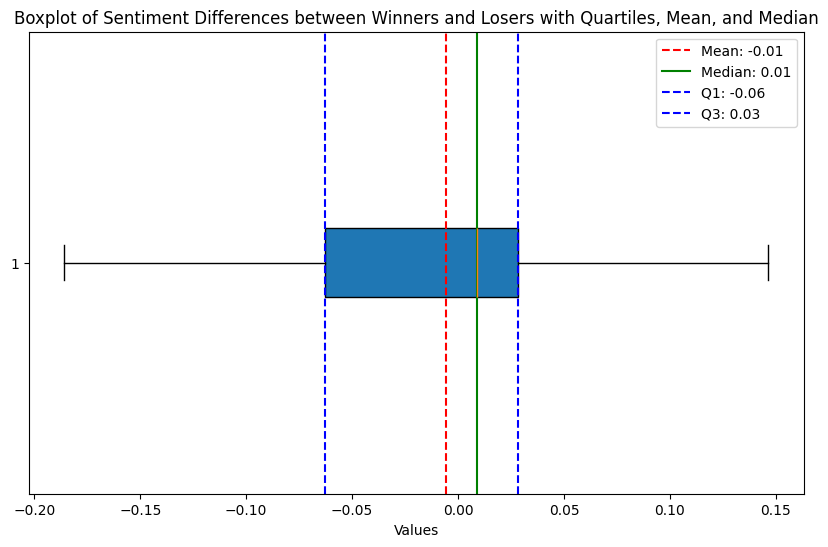

In [167]:
q1 = np.percentile(sentiment_diffs, 25)
q3 = np.percentile(sentiment_diffs, 75)
iqr = q3 - q1
mean = np.mean(sentiment_diffs)
median = np.median(sentiment_diffs)

plt.figure(figsize=(10, 6))
plt.boxplot(sentiment_diffs, vert=False, patch_artist=True, showfliers=False)
plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
plt.axvline(q1, color='b', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(q3, color='b', linestyle='--', label=f'Q3: {q3:.2f}')
plt.xlabel('Values')
plt.title('Boxplot of Sentiment Differences between Winners and Losers with Quartiles, Mean, and Median')
plt.legend(loc='upper right')
plt.show()

In [175]:
gf_diffs = []

for i in date_dict.keys():
    year = i.split("/")[-1]
    prez_winner = winners[int(year)]

    winner_gf = textstat.gunning_fog(transcript_by_speaker[i][prez_winner])
    loser = next((key for key in words_by_speaker[i].keys() if key != prez_winner), None)
    loser_gf = textstat.gunning_fog(transcript_by_speaker[i][loser])
    gf_diff = winner_gf - loser_gf
    gf_diffs.append(gf_diff)
    print(f"Year: {year}")
    print(f"Gunning Fog Difference: {gf_diff}")
    

Year: 2008
Gunning Fog Difference: 1.8200000000000003
Year: 1960
Gunning Fog Difference: -2.130000000000001
Year: 2020
Gunning Fog Difference: 1.3399999999999999
Year: 1984
Gunning Fog Difference: 0.9399999999999995
Year: 2012
Gunning Fog Difference: 1.8999999999999995
Year: 1960
Gunning Fog Difference: 0.1800000000000015
Year: 2012
Gunning Fog Difference: 2.259999999999999
Year: 2000
Gunning Fog Difference: -1.5899999999999999
Year: 1976
Gunning Fog Difference: -0.35999999999999943
Year: 1988
Gunning Fog Difference: -1.1399999999999997
Year: 2016
Gunning Fog Difference: -2.7300000000000004
Year: 1988
Gunning Fog Difference: -1.4400000000000013
Year: 2000
Gunning Fog Difference: -1.5
Year: 2016
Gunning Fog Difference: -2.9299999999999997
Year: 1960
Gunning Fog Difference: -3.4299999999999997
Year: 2000
Gunning Fog Difference: -1.959999999999999
Year: 1984
Gunning Fog Difference: 1.7400000000000002
Year: 2020
Gunning Fog Difference: 0.9500000000000002
Year: 1976
Gunning Fog Difference: 

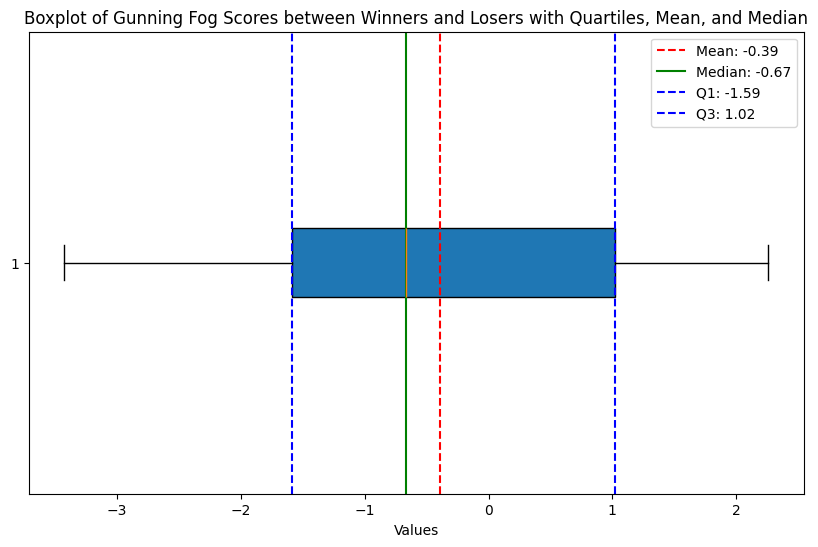

In [172]:
q1 = np.percentile(gf_diffs, 25)
q3 = np.percentile(gf_diffs, 75)
iqr = q3 - q1
mean = np.mean(gf_diffs)
median = np.median(gf_diffs)

plt.figure(figsize=(10, 6))
plt.boxplot(gf_diffs, vert=False, patch_artist=True, showfliers=False)
plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
plt.axvline(q1, color='b', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(q3, color='b', linestyle='--', label=f'Q3: {q3:.2f}')
plt.xlabel('Values')
plt.title('Boxplot of Gunning Fog Scores between Winners and Losers with Quartiles, Mean, and Median')
plt.legend(loc='upper right')
plt.show()